# Simulating Capillary Pressure Curve on an Extracted Network

In this tutorial we will dive into the process of extracting a network from an image, then we'll compute the capillary pressure curve using the extract network, and compare to the image-based drainage simulation in PoreSpy.

As usual, let's import the needed packages:

In [79]:
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np


## Generate an Image

Let's use a 2D generated image, for quicker processing and easier visualization:

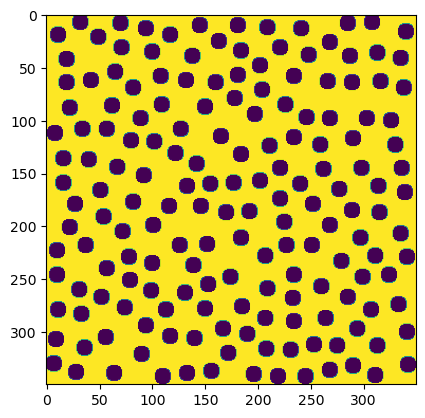

In [99]:
im = ~ps.generators.rsa([350, 350], r=8, clearance=3)
plt.imshow(im);


## Perform Drainage on Image

In [100]:
inlets = ps.tools.get_border(shape=im.shape, mode='edges')
drn = ps.simulations.drainage(im, inlets=inlets, sigma=0.480, theta=140, voxel_size=1e-5)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

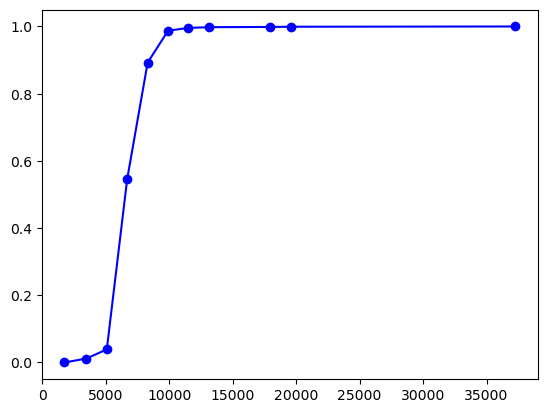

In [101]:
plt.plot(drn.pc, drn.snwp, 'bo-');


## Extract the Network

We'll use the ``snow2`` function in PoreSpy:

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/274 [00:00<?, ?it/s]

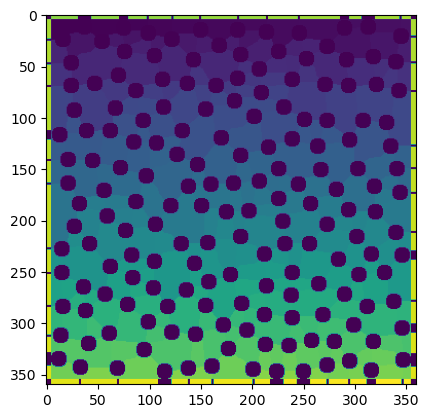

In [102]:
snow = ps.networks.snow2(im, boundary_width=5, voxel_size=1e-5)
plt.imshow(snow.regions);


In [103]:
pn = op.io.network_from_porespy(snow.network)
print(pn)



══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x289a9da38b0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                    440 / 440
  3  pore.coords                                                     274 / 274
  4  pore.region_label                                               274 / 274
  5  pore.phase                                                      274 / 274
  6  throat.phases                                                   440 / 440
  7  pore.region_volume                                              274 / 274
  8  pore.equivalent_diameter                                        274 / 274
  9  pore.local_peak                                                 274 / 274
 1

## Define Pore and Throat Sizes

PoreSpy returns many different pieces of size information, but does not make any choices about *which* ones to use in OpenPNM. 

For instance, there are 3 different value of pore diameter, but none are ``'pore.diameter'``.  We must choose.

In [110]:
pn['pore.diameter'] = pn['pore.inscribed_diameter']
pn['pore.volume'] = pn['pore.region_volume']
pn['throat.diameter'] = pn['throat.inscribed_diameter']*2
pn['throat.volume'] = 0.0


## Define Thermodynamic and Capillary Properties

We need to create a Phase object to represent the mercury, with its surface tension and contact angle.  

We also need to define the physical law for capillary entry pressure:

In [111]:
hg = op.phase.Mercury(network=pn)
hg.add_model(propname='throat.entry_pressure', 
             model=op.models.physics.capillary_pressure.washburn)


## Create Drainage Algorithm


In [112]:
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores(['xmin', 'xmax', 'ymin', 'ymax']))
mip.run()


Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

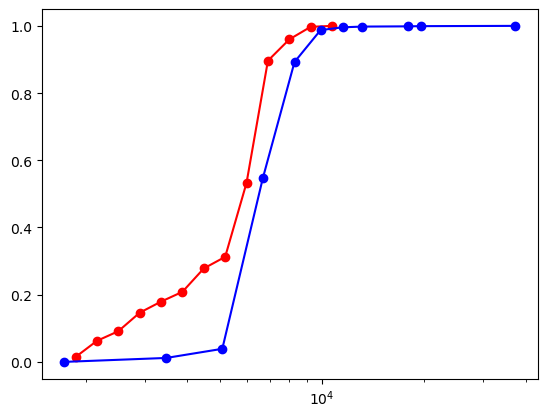

In [113]:
data = mip.pc_curve()
plt.semilogx(data.pc, data.snwp, 'ro-')
plt.semilogx(drn.pc, drn.snwp, 'bo-');
